# Exploratory Data Analysis

## Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Create an engine to connect to the SQLite database
db_path = 'data/agri.db'
engine = create_engine(f'sqlite:///{db_path}')

# Define your SQL query to fetch all data from a specific table
query = """
SELECT * FROM farm_data;
"""

# Execute the query and load results into a DataFrame
df = pd.read_sql_query(query, engine)

# Process and display results
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57489 entries, 0 to 57488
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   System Location Code          57489 non-null  object 
 1   Previous Cycle Plant Type     57489 non-null  object 
 2   Plant Type                    57489 non-null  object 
 3   Plant Stage                   57489 non-null  object 
 4   Temperature Sensor (°C)       48800 non-null  float64
 5   Humidity Sensor (%)           18622 non-null  float64
 6   Light Intensity Sensor (lux)  53211 non-null  float64
 7   CO2 Sensor (ppm)              57489 non-null  int64  
 8   EC Sensor (dS/m)              57489 non-null  float64
 9   O2 Sensor (ppm)               57489 non-null  int64  
 10  Nutrient N Sensor (ppm)       47515 non-null  object 
 11  Nutrient P Sensor (ppm)       51791 non-null  object 
 12  Nutrient K Sensor (ppm)       53788 non-null  object 
 13  p

In [3]:
# Rename coloumns for consistency
# Rational: Standardize the column names to make it easier to work with the data
df.rename(columns={
    'System Location Code': 'location',
    'Previous Cycle Plant Type': 'prePlantType',
    'Plant Type': 'currentPlantType',
    'Plant Stage': 'plantStage',
    'Temperature Sensor (°C)': 'temperature',
    'Humidity Sensor (%)': 'humidity',
    'Light Intensity Sensor (lux)': 'lightIntSensor',
    'CO2 Sensor (ppm)': 'co2Sensor',
    'EC Sensor (dS/m)': 'ecSensor',
    'O2 Sensor (ppm)': 'o2Sensor',
    'Nutrient N Sensor (ppm)': 'nSensor',
    'Nutrient P Sensor (ppm)': 'pSensor',
    'Nutrient K Sensor (ppm)': 'kSensor',
    'pH Sensor': 'phSensor',
    'Water Level Sensor (mm)': 'waterLevel'
}, inplace=True)

# Display the updated DataFrame with renamed columns
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57489 entries, 0 to 57488
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   location          57489 non-null  object 
 1   prePlantType      57489 non-null  object 
 2   currentPlantType  57489 non-null  object 
 3   plantStage        57489 non-null  object 
 4   temperature       48800 non-null  float64
 5   humidity          18622 non-null  float64
 6   lightIntSensor    53211 non-null  float64
 7   co2Sensor         57489 non-null  int64  
 8   ecSensor          57489 non-null  float64
 9   o2Sensor          57489 non-null  int64  
 10  nSensor           47515 non-null  object 
 11  pSensor           51791 non-null  object 
 12  kSensor           53788 non-null  object 
 13  phSensor          57489 non-null  float64
 14  waterLevel        48847 non-null  float64
dtypes: float64(6), int64(2), object(7)
memory usage: 6.6+ MB
None


## Data Issues Check And Fix
<ol>
    <li>Assign appropriate data types to specified columns.</li>
    <li>Convert categorical variables to lowercase.</li>
    <li>Set order for plantStage = 'seedling' < 'vegetative' < 'maturity'.</li>
    <li>Remove ' ppm' from n, p and k sensors data, and change them to 'float'.</li>
    <li>After verifying, accept absolute values in npk sensors by using .abs() function to correct them. This is based on the assumption that '-' was erroneously added.</li>
    <li>Identify duplicates and decide on a strategy to handle them. After verification, duplicates are safe to remove.</li>
    <li>Ensure that categorical data is consistent and valid.</li>
    <li>Identify any missing values in the dataset and decide on a strategy to handle them (e.g., imputation, removal). As 'humidity' is an important variable in predicting temperature and plant growth, the working data will consist of this subset (total of 16,214 records). Therefore, all null in numerical data fields are imputed with their respective median values. This helps populate lesser synthetic data. </li>
    <li>Apply necessary fixes and summarize the clean dataset, then assign as new dataframe named df_humidity, which contains 16,214 records.</li>
</ol>

In [4]:
# Convert specified categorical columns to lower case
categorical_columns = ['location', 'prePlantType', 'currentPlantType', 'plantStage']

for col in categorical_columns:
    df[col] = df[col].str.lower()

# Define the order of the categories
stage_order = ['seedling', 'vegetative', 'maturity']

# Change the plantStage column to categorical with ordered categories
df['plantStage'] = pd.Categorical(df['plantStage'], categories=stage_order, ordered=True)

# Change the specified columns to category data type
df['location'] = df['location'].astype('category')
df['prePlantType'] = df['prePlantType'].astype('category')
df['currentPlantType'] = df['currentPlantType'].astype('category')
df['ecSensor'] = df['ecSensor'].astype('int64')

# Remove ' ppm' from the nSensor, pSensor, and kSensor columns
df['nSensor'] = df['nSensor'].str.replace(' ppm', '', regex=False).astype(float)
df['pSensor'] = df['pSensor'].str.replace(' ppm', '', regex=False).astype(float)
df['kSensor'] = df['kSensor'].str.replace(' ppm', '', regex=False).astype(float)

# Correct negative values by taking the absolute value using .loc
df.loc[:, 'temperature'] = df['temperature'].abs()
df.loc[:, 'lightIntSensor'] = df['lightIntSensor'].abs()
df.loc[:, 'ecSensor'] = df['ecSensor'].abs()

print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57489 entries, 0 to 57488
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   location          57489 non-null  category
 1   prePlantType      57489 non-null  category
 2   currentPlantType  57489 non-null  category
 3   plantStage        57489 non-null  category
 4   temperature       48800 non-null  float64 
 5   humidity          18622 non-null  float64 
 6   lightIntSensor    53211 non-null  float64 
 7   co2Sensor         57489 non-null  int64   
 8   ecSensor          57489 non-null  int64   
 9   o2Sensor          57489 non-null  int64   
 10  nSensor           47515 non-null  float64 
 11  pSensor           51791 non-null  float64 
 12  kSensor           53788 non-null  float64 
 13  phSensor          57489 non-null  float64 
 14  waterLevel        48847 non-null  float64 
dtypes: category(4), float64(8), int64(3)
memory usage: 5.0 MB
None


In [5]:
# Check for duplicates
duplicates = df.duplicated()

# View duplicate rows
duplicate_rows = df[duplicates]
print("\nDuplicate rows:")
print(duplicate_rows)

# Count the number of duplicate rows
duplicate_count = duplicates.sum()
print(f"\nNumber of duplicate rows: {duplicate_count}")

# Remove duplicates
# Rational: Duplicates can affect the accuracy of the analysis and model performance. Removed to ensure data quality.
df = df.drop_duplicates()
print("\nShape of DataFrame after removing duplicates:")
print(df.info())


Duplicate rows:
      location         prePlantType     currentPlantType  plantStage  \
8       zone_g                herbs         leafy greens    maturity   
15      zone_b                herbs  fruiting vegetables    maturity   
29      zone_c         leafy greens         leafy greens  vegetative   
37      zone_b           vine crops         leafy greens    seedling   
40      zone_f                herbs                herbs  vegetative   
...        ...                  ...                  ...         ...   
57446   zone_a         leafy greens  fruiting vegetables    seedling   
57455   zone_d           vine crops           vine crops    seedling   
57468   zone_a         leafy greens         leafy greens  vegetative   
57477   zone_a  fruiting vegetables  fruiting vegetables  vegetative   
57485   zone_c           vine crops  fruiting vegetables    maturity   

       temperature  humidity  lightIntSensor  co2Sensor  ecSensor  o2Sensor  \
8            20.16       NaN           

In [6]:
# Checking for inconsistent or invalid data with categorical datatype
unique_location = df['location'].unique()
unique_prePlantType = df['prePlantType'].unique()
unique_currentPlantType = df['currentPlantType'].unique()
unique_plantStage = df['plantStage'].unique()

print(unique_location, unique_prePlantType, unique_currentPlantType, unique_plantStage, sep='\n')

['zone_d', 'zone_g', 'zone_f', 'zone_b', 'zone_c', 'zone_a', 'zone_e']
Categories (7, object): ['zone_a', 'zone_b', 'zone_c', 'zone_d', 'zone_e', 'zone_f', 'zone_g']
['herbs', 'vine crops', 'leafy greens', 'fruiting vegetables']
Categories (4, object): ['fruiting vegetables', 'herbs', 'leafy greens', 'vine crops']
['vine crops', 'herbs', 'fruiting vegetables', 'leafy greens']
Categories (4, object): ['fruiting vegetables', 'herbs', 'leafy greens', 'vine crops']
['maturity', 'vegetative', 'seedling']
Categories (3, object): ['seedling' < 'vegetative' < 'maturity']


In [7]:
# Handling missing data
# Rational: Impute median values for columns with nulls in df (excluding humidity) to maintain data integrity
for column in df.columns:
    if column != 'humidity' and df[column].isnull().any():
        median_value = df[column].median()
        df.loc[df[column].isnull(), column] = median_value

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 0 to 57488
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   location          50000 non-null  category
 1   prePlantType      50000 non-null  category
 2   currentPlantType  50000 non-null  category
 3   plantStage        50000 non-null  category
 4   temperature       50000 non-null  float64 
 5   humidity          16214 non-null  float64 
 6   lightIntSensor    50000 non-null  float64 
 7   co2Sensor         50000 non-null  int64   
 8   ecSensor          50000 non-null  int64   
 9   o2Sensor          50000 non-null  int64   
 10  nSensor           50000 non-null  float64 
 11  pSensor           50000 non-null  float64 
 12  kSensor           50000 non-null  float64 
 13  phSensor          50000 non-null  float64 
 14  waterLevel        50000 non-null  float64 
dtypes: category(4), float64(8), int64(3)
memory usage: 4.8 MB
None


In [8]:
# Capture all rows with non-null humidity data and create a new DataFrame
df_humidity = df[df['humidity'].notnull()]

print(df_humidity.info())

<class 'pandas.core.frame.DataFrame'>
Index: 16214 entries, 1 to 57487
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   location          16214 non-null  category
 1   prePlantType      16214 non-null  category
 2   currentPlantType  16214 non-null  category
 3   plantStage        16214 non-null  category
 4   temperature       16214 non-null  float64 
 5   humidity          16214 non-null  float64 
 6   lightIntSensor    16214 non-null  float64 
 7   co2Sensor         16214 non-null  int64   
 8   ecSensor          16214 non-null  int64   
 9   o2Sensor          16214 non-null  int64   
 10  nSensor           16214 non-null  float64 
 11  pSensor           16214 non-null  float64 
 12  kSensor           16214 non-null  float64 
 13  phSensor          16214 non-null  float64 
 14  waterLevel        16214 non-null  float64 
dtypes: category(4), float64(8), int64(3)
memory usage: 1.5 MB
None


## Feature Enginering

Combine 'plantTypeStage' and 'currentPlantType' into a new column, 'plantTypeStage'. This new column will be of categorical data type.

In [9]:
# Feature Engineering

# Combine currentPlantType and plantStage into a new column
df_humidity['plantTypeStage'] = df_humidity['currentPlantType'].astype(str) + '_' + df_humidity['plantStage'].astype(str)

# Convert the new column to categorical
df_humidity['plantTypeStage'] = df_humidity['plantTypeStage'].astype('category')

# Check the result
print(df_humidity[['currentPlantType', 'plantStage', 'plantTypeStage']].head())
print(f'\nData type of plantTypeStage column: {df_humidity["plantTypeStage"].dtype}')

       currentPlantType  plantStage                plantTypeStage
1            vine crops  vegetative         vine crops_vegetative
11  fruiting vegetables    maturity  fruiting vegetables_maturity
12         leafy greens    seedling         leafy greens_seedling
18         leafy greens    seedling         leafy greens_seedling
19                herbs    seedling                herbs_seedling

Data type of plantTypeStage column: category


## Part 2: Data Visualisation

### Univariate analysis

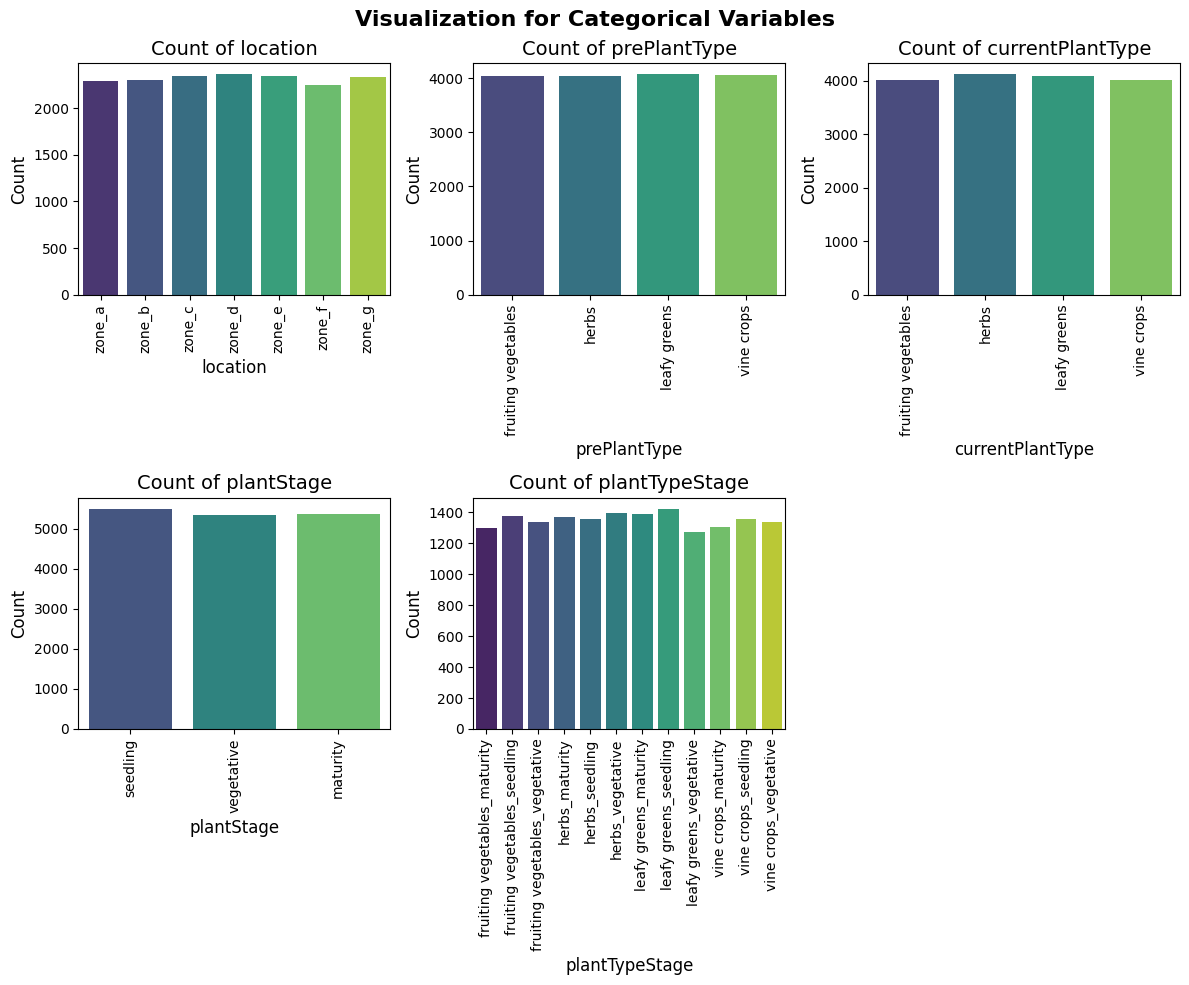

In [10]:
# Set up the figure and axes for a 2x2 grid
fig, axes = plt.subplots(2, 3, figsize=(12, 10))
axes = axes.flatten()

# List of categorical columns to plot
categorical_columns = ['location', 'prePlantType', 'currentPlantType', 'plantStage', 'plantTypeStage']

# Add a main title for the entire figure
fig.suptitle('Visualization for Categorical Variables', fontsize=16, fontweight='bold')

# Loop through each categorical column and create a bar plot
for i, column in enumerate(categorical_columns):
    # Count occurrences of each category
    counts = df_humidity[column].value_counts()
    
    # Create a bar plot with hue set to the column itself and legend turned off
    sns.barplot(x=counts.index, y=counts.values, ax=axes[i], palette='viridis', hue=counts.index, legend=False)
    
    # Set titles and labels
    axes[i].set_title(f'Count of {column}', fontsize=14)
    axes[i].set_xlabel(column, fontsize=12)
    axes[i].set_ylabel('Count', fontsize=12)
    axes[i].tick_params(axis='x', rotation=90)

# Hide any unused subplots if there are fewer plots than subplots created
for j in range(len(categorical_columns), len(axes)):
    axes[j].axis('off')
    
# Adjust layout
plt.tight_layout()
plt.show()

### Summary of categorical data:

There are 5 fields of categorical data: 'location', 'prePlantType', 'currentPlantType', 'plantStage', and 'plantTypeStage'. The bar charts show that the data of each field is evenly distributed.

<Figure size 640x480 with 0 Axes>

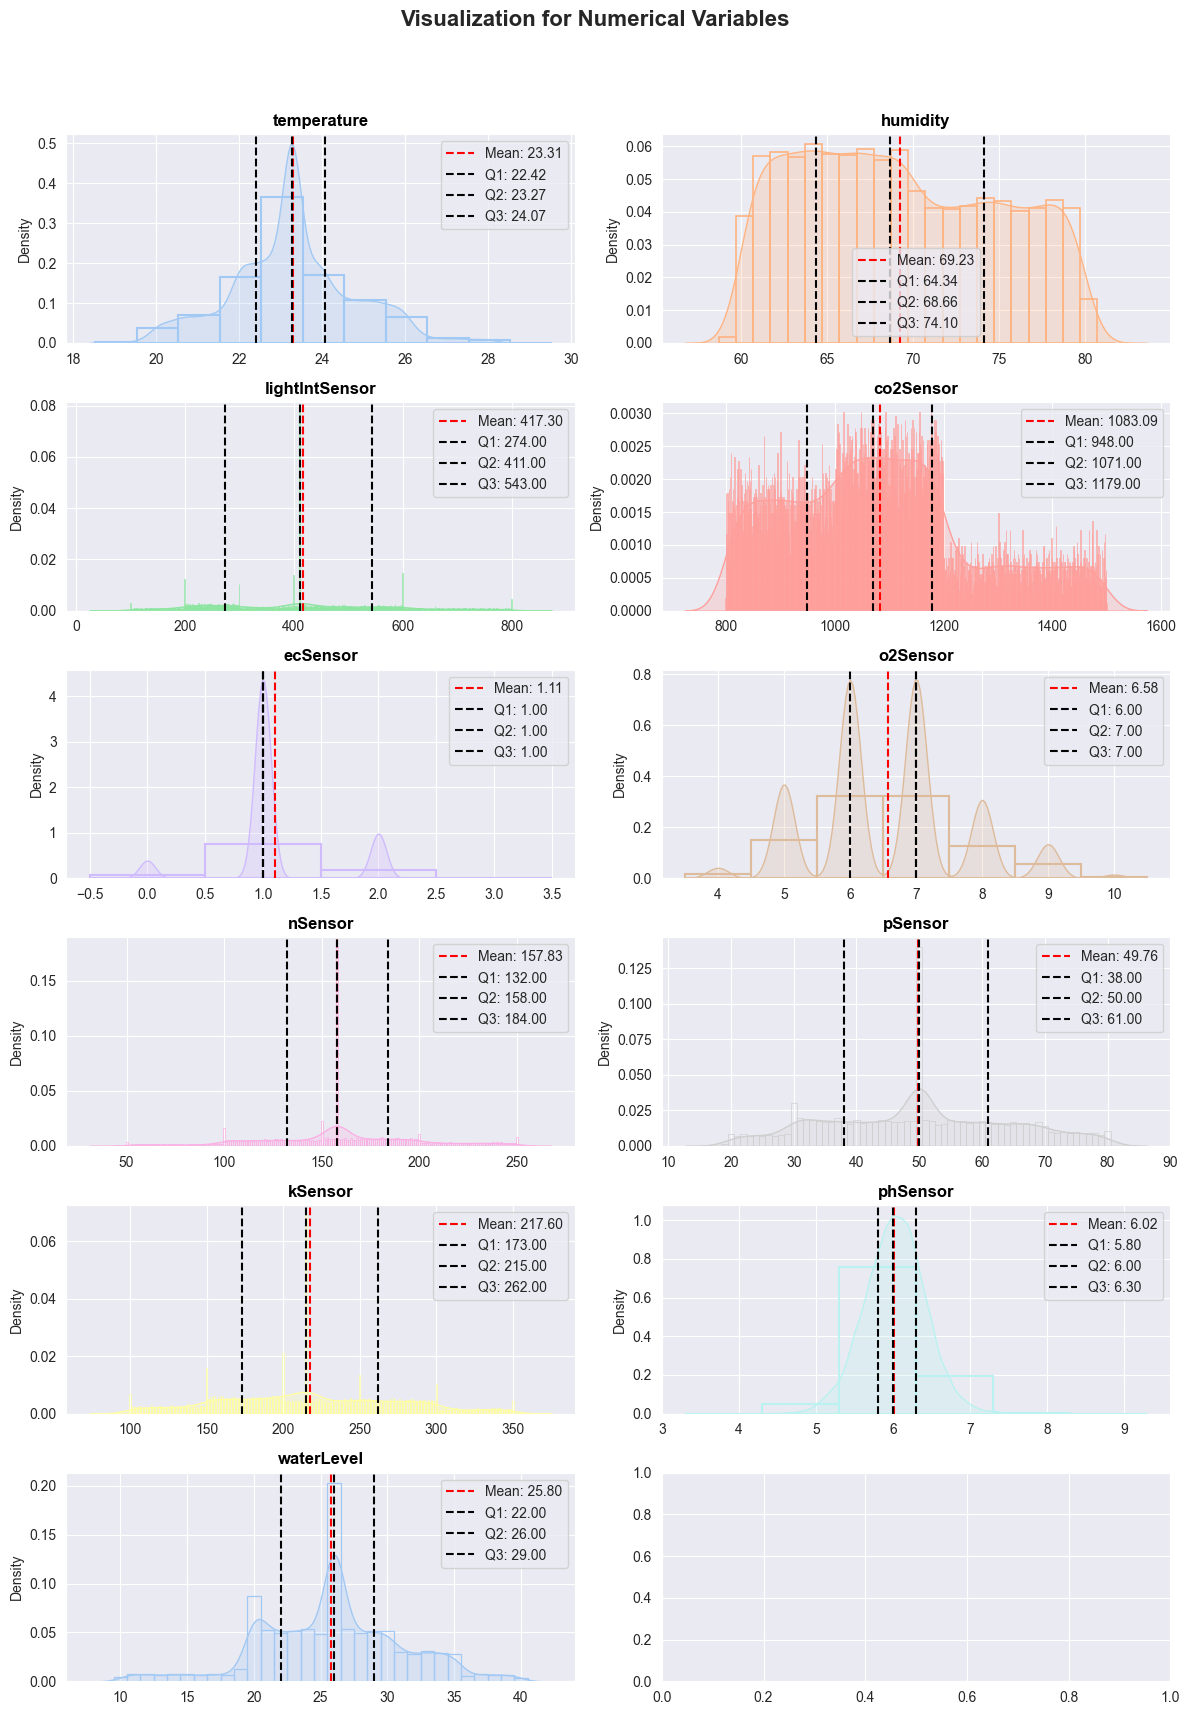

In [11]:
# Select numerical fields
numerical_fields = df_humidity.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Clear the current figure
plt.clf()

# Set the style and color palette
sns.set_style("darkgrid")
colors = sns.color_palette(palette='pastel', n_colors=len(numerical_fields))

# Create subplots: Adjust nrows and ncols based on the number of numerical fields
num_plots = len(numerical_fields)
ncols = 2
nrows = (num_plots + ncols - 1) // ncols

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, nrows * 3))
ax = ax.flat

# Add a main title for the entire figure
fig.suptitle('Visualization for Numerical Variables', fontsize=16, fontweight='bold')

# Loop through each numerical field to create histograms and KDE plots
for i, col in enumerate(numerical_fields):
    mu = df_humidity[col].mean()
    q1, q2, q3 = df_humidity[col].quantile([0.25, 0.5, 0.75])
    
    # Histogram plot
    sns.histplot(df_humidity[col], stat='density', fill=False, discrete=True, color=colors[i], ax=ax[i], bins=30)
    
    # KDE plot
    sns.kdeplot(df_humidity[col], color=colors[i], fill=True, ax=ax[i])
    
    # Mean and quantile lines
    ax[i].axvline(mu, linestyle='--', color='r', label=f"Mean: {mu:.2f}")
    ax[i].axvline(q1, linestyle='--', color='black', label=f"Q1: {q1:.2f}")
    ax[i].axvline(q2, linestyle='--', color='black', label=f"Q2: {q2:.2f}")
    ax[i].axvline(q3, linestyle='--', color='black', label=f"Q3: {q3:.2f}")
    
    # Adding legend and title
    ax[i].legend()
    ax[i].set_xlabel("")
    ax[i].set_title(f"{col}", fontweight='bold', color='black')

# Hide any unused subplots if there are fewer plots than subplots created
for j in range(len(categorical_columns), len(axes)):
    axes[j].axis('off')
    
# Adjust layout for better spacing
fig.tight_layout(rect=[0, 0.03, 1, 0.95]) # To make space for the main title
plt.show()

### Summary of numerical data:

| Feature         | Description                                         |
|------------------|-----------------------------------------------------|
| Temperature      | Shows a moderate normal distribution centered around 23.3 degrees Celsius. |
| Humidity         | Displays a bimodal distribution with peaks around 64% and 74%. |
| Light Intensity  | Data is spread over a wide range with majority between 150 lux and 800 lux. |
| co2              | Data is spread over a wide range between 800 ppm and 1500 ppm. It has a multimodal distribution with many peaks. |
| Electrical Conductivity (ec) | Values fall between 0 ds/m and 2 ds/m with a majority at 1 ds/m. |
| o2               | Majority of the data falls between 4 ppm and 10 ppm, with peaks at 6 ppm and 7 ppm. |
| n Sensor         | Moderate distribution but data is spread over a wide range between 50 ppm and 250 ppm. |
| p Sensor         | Data is evenly distributed with mean is close to median values around 50 ppm. |
| k Sensor         | Data is slightly skewed to the right, which suggests more data is having values greater than 215 ppm. |
| ph Sensor        | Majority of the ph values is approximately at 6. |
| Water Level      | Displays a multimodal distribution with majority of the values falling between 20 mm and 35 mm. | 

### Bivariate analysis

Temperature against Numerical Data

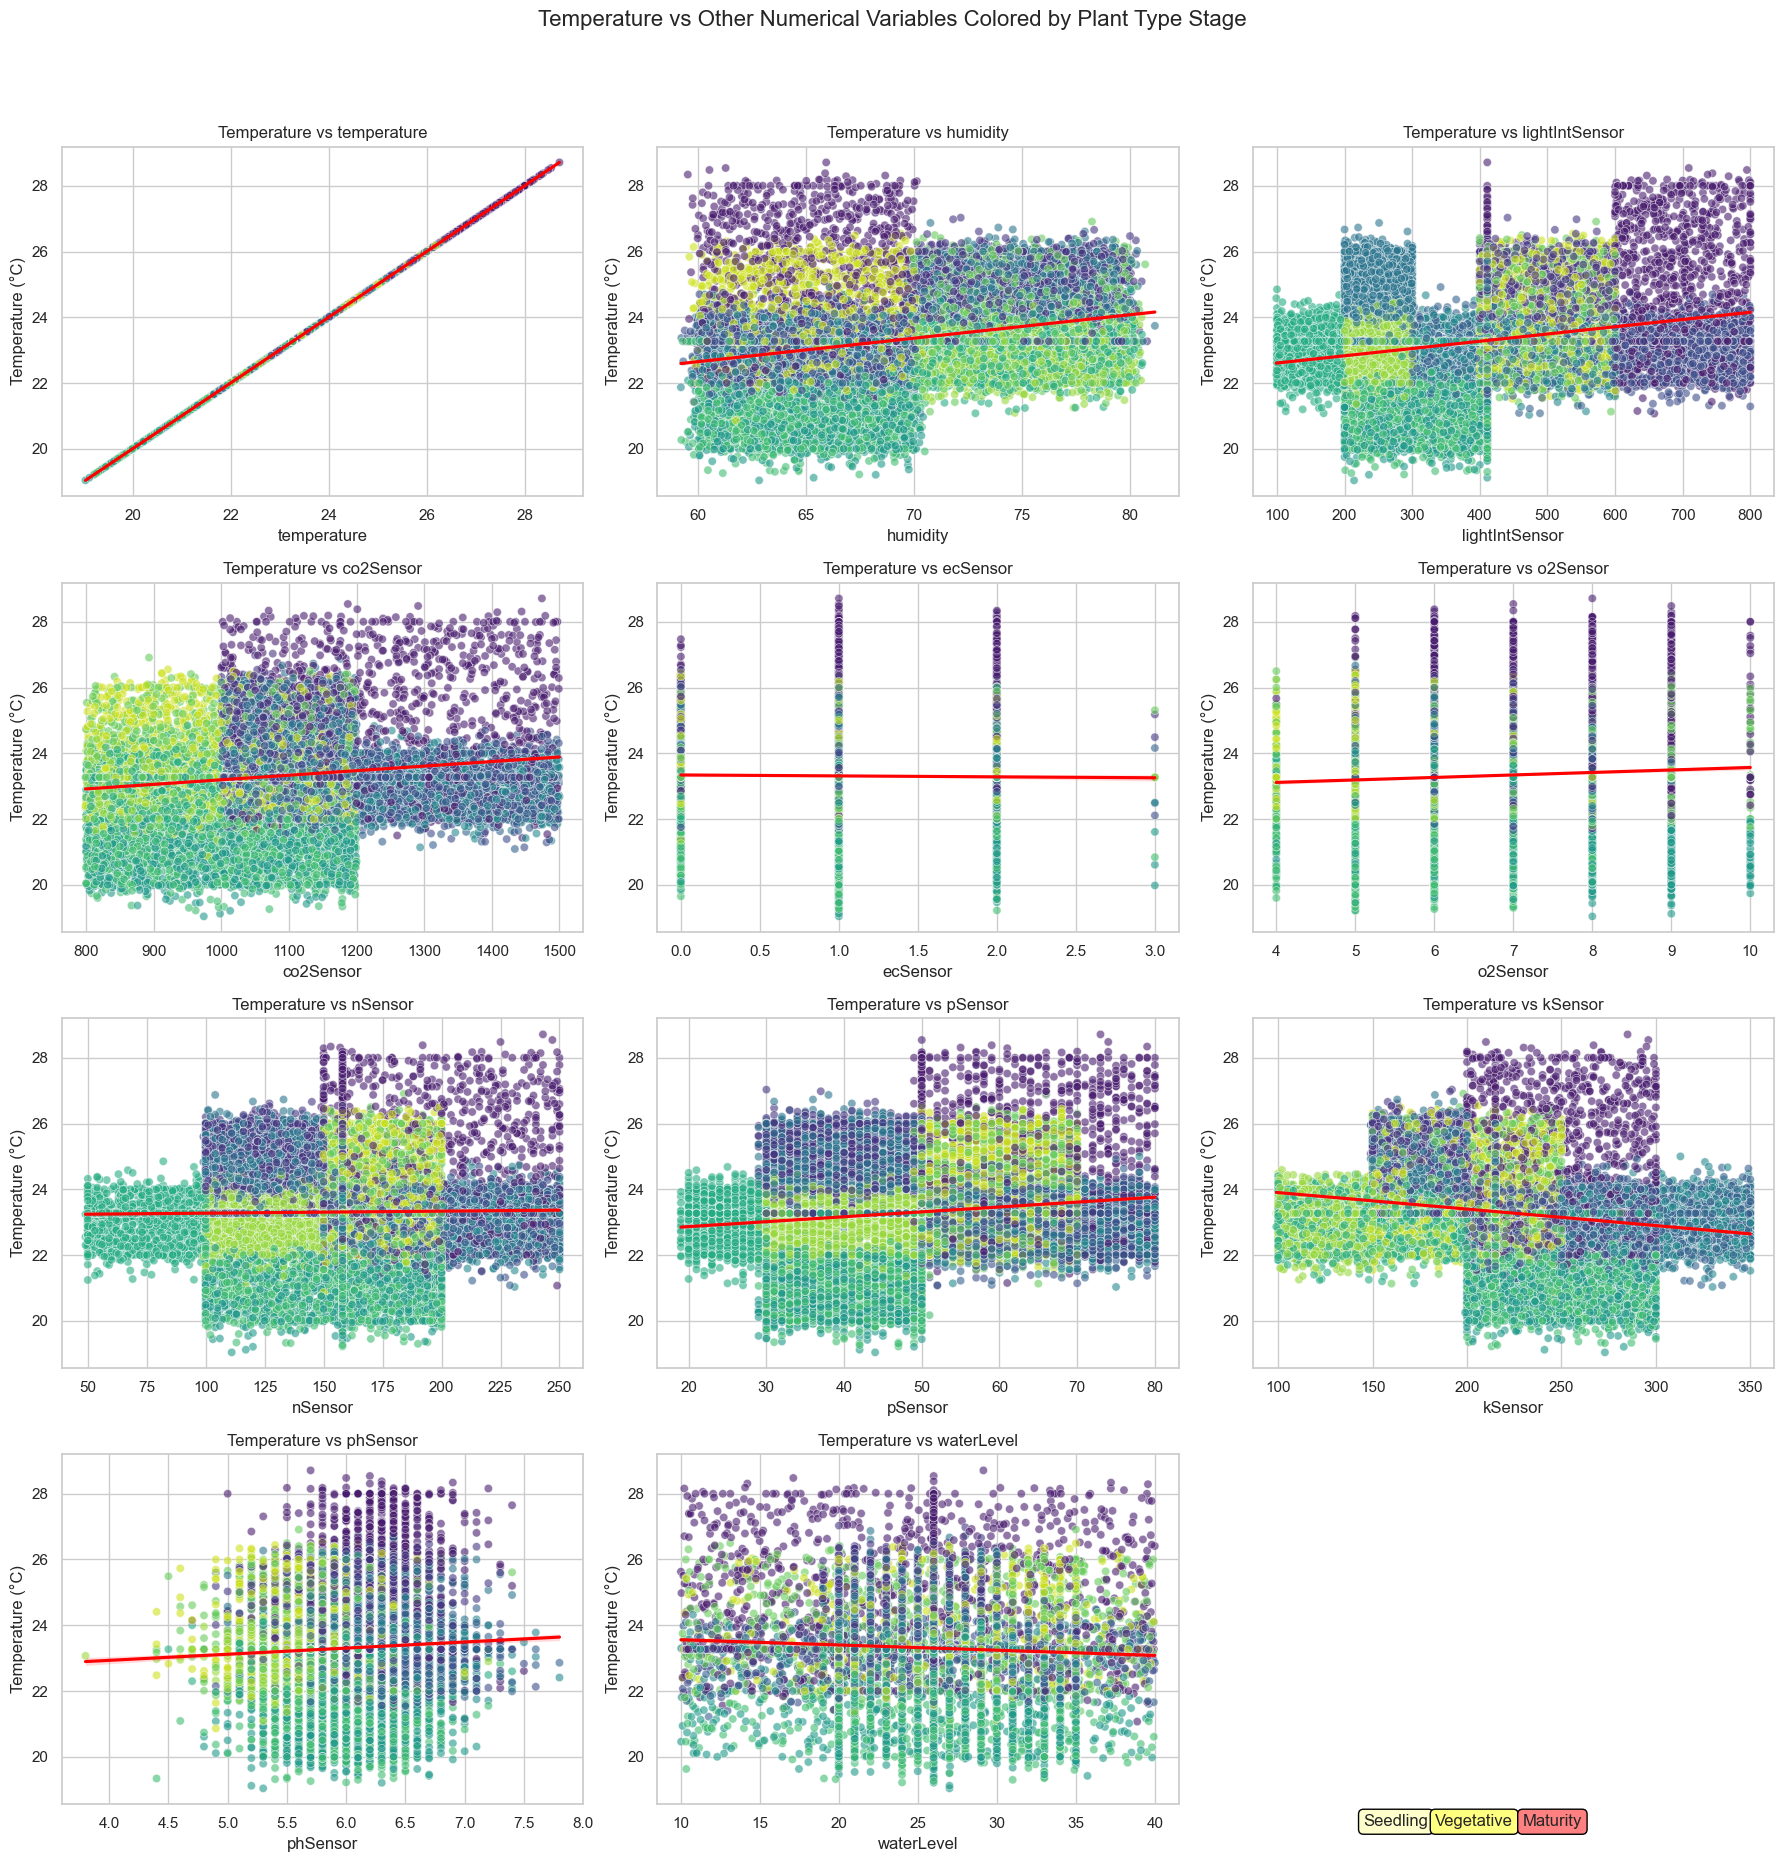

In [12]:
# Set the style for the plots
sns.set(style="whitegrid")

# Create a figure with subplots based on the number of numerical fields
num_plots = len(numerical_fields)
ncols = min(num_plots -1 ,3) # Set to a maximum of three columns; exclude plantTypeStage itself
nrows = (num_plots + ncols -1 ) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18,nrows*5))
axes = axes.flatten() # Flatten the array of axes for easy iteration

# Add a main title for the entire figure
fig.suptitle('Temperature vs Other Numerical Variables Colored by Plant Type Stage', fontsize=16)

# Loop through each numerical field to create scatter plots with regression lines
for i, col in enumerate(numerical_fields):
    if col != 'plantTypeStage': # Avoid plotting plantTypeStage against itself
        
        # Create scatter plot using plantTypeStage for hue
        sns.scatterplot(data=df_humidity, x=col, y='temperature', ax=axes[i], alpha=0.6,
                        hue='plantTypeStage', palette='viridis', legend=False)
        
        sns.regplot(data=df_humidity, x=col, y='temperature', ax=axes[i], scatter=False, color='red')
        
        # Set titles and labels
        axes[i].set_title(f'Temperature vs {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Temperature (°C)')

# Manually create a legend for plant stages below the title using one of the unused plots
colors = {'Seedling': (1, 1, 0.8), 'Vegetative': (1, 1, 0.5), 'Maturity': (1, 0.5, 0.5)}
legend_labels = list(colors.keys())
legend_colors = [colors[label] for label in legend_labels]

# Add legend below the title in an unused subplot space
for idx, label in enumerate(legend_labels):
    axes[-1].text(0.5 + idx * 0.15 - len(legend_labels) * 0.075, -0.05,
                  label,
                  ha='center',
                  va='center',
                  fontsize=12,
                  bbox=dict(facecolor=legend_colors[idx], edgecolor='black', boxstyle='round,pad=0.3'))

# Hide any unused subplots if there are fewer plots than subplots created
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0.05, 1, 0.95]) # To make space for the main title and legend
plt.show()

### Summary of bivariate analysis

The charts serve to confirm the relationship among temperature, humidity, light intensity, co2 and water level.

| Feature         | Description                                         |
|-----------------|-----------------------------------------------------|
| Humidity        | High humidity can trap heat and potentially raise temperature | 
| Light Intensity | Light contributes to heating |
| co2             | A greenhouse gas which contributes to warming |
| Water Level     | Can be due to rainfall or irrigation; both can lower the temperature |

Data from other sensors are specific to types and growth stages of plants, and can aid in classifying Plant Type-Stage.

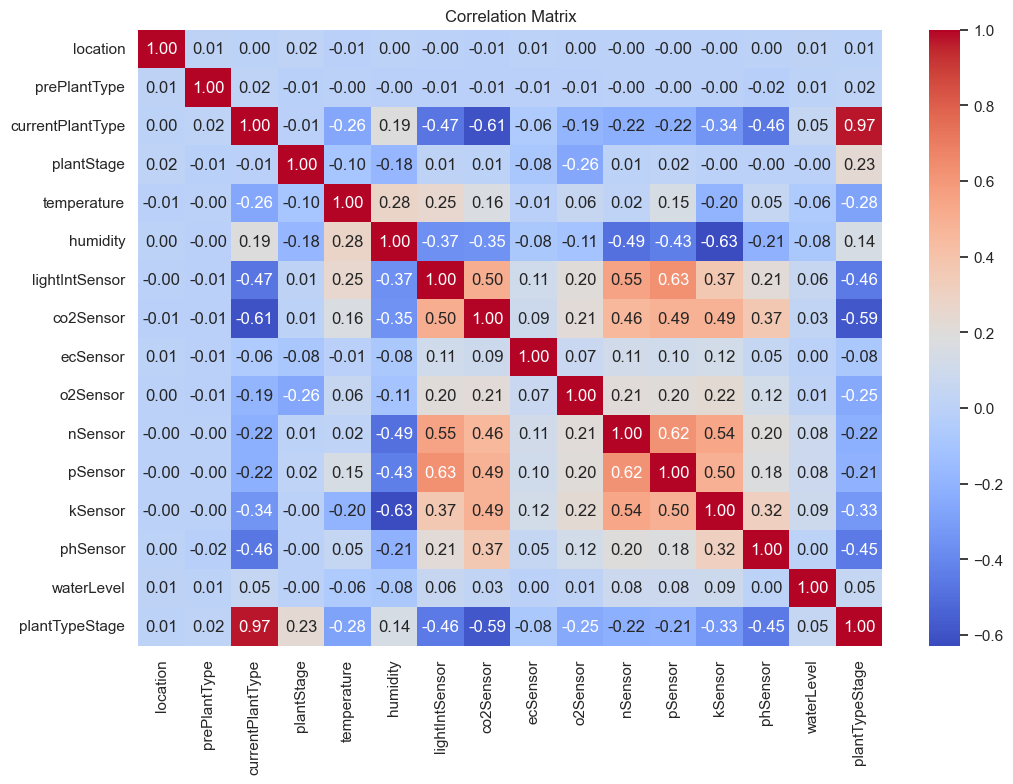

In [13]:
# Encode categorical fields with numerical values
label_encoders = {}

# Encode via looping through categorical fields
for feature in categorical_columns:
    le = LabelEncoder()
    # Fit and transform the feature and convert to int (or str if needed)
    encoded_values = le.fit_transform(df_humidity[feature])
    
    # Assign back to the DataFrame ensuring it's compatible
    df_humidity.loc[:, feature] = encoded_values.astype(int)  # Ensure it's of integer type

    # Store the label encoder for future use if needed
    label_encoders[feature] = le

# Calculate the correlation matrix for numeric columns
numeric_df = df_humidity.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix for numeric columns
correlation_matrix = numeric_df.corr()

# Plot correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


### Summary of Correlation Matrix

Task 1 - Predict Temperature Conditions  
The matrix shows mild correlation between temperature and other environmental factors, which can aid in predicting temperature conditions. The model could utilise humidity (0.28), light intensity(0.25) and co2 (0.16) as inputs for prediction. Water level (-0.06) appears to have negligible predictive power for temperature.

Task 2 - Categorise Plant Type-Stage using sensor data  
To categorize plant type stage using sensor data, we need to look at the correlations between plantTypeStage and various sensor readings:

| Feature         | Description                                         |
|-----------------|-----------------------------------------------------|
| co2             | Strong negative correlation (-0.59) |
| Light Intensity | Moderate negative correlation (-0.46) |
| ph Sensor       | Moderate negative correlation (-0.45) |
| k Sensor        | Moderate negative correlation (-0.33) |
| Temperature     | Weak negative correlation (-0.28) |
| o2 Sensor       | Weak negative correlation (-0.25) |
| n Sensor        | Weak negative correlation (-0.22) |
| p Sensor        | Weak negative correlation (-0.21) |
| Humidity        | Weak positive correlation (0.14)  |
| ec Sensor       | Weak negative correlation (-0.08) |
| Water Level     | Weak positive correlation (0.05)  |

All readings from the 11 sensors will be used to in the task to categorise the combine 'Plant Type-Stage'.

# End of EDA
